## https://www.kaggle.com/sauravjoshi23/text-classification-using-siamesenet-glove


# Check every comment in this notebook and understand it. You will have to uncomment according to need.

In [142]:
import pandas as pd
import numpy as np
import random
import warnings
import time
import datetime
import re
import string
import itertools
import pickle
import joblib
import nltk
import csv
from nltk.corpus import stopwords, wordnet
stop = set(stopwords.words('english'))
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter, defaultdict
from keras.utils import np_utils

import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate,Embedding, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [143]:
train_data_file_m = '/data/parush/stance_mohammed/new_train.txt'
test_data_file_m = '/data/parush/stance_mohammed/new_test.txt'
TARGETS_m = [ 'Atheism','Climate Change is a Real Concern', 'Feminist Movement','Hillary Clinton', 'Legalization of Abortion', 'Donald Trump']




In [144]:
def df_gen_mohammed(train_data_file_m,pos_target_label,neg_target_label ):
    
    df = pd.DataFrame(columns=['text', 'target'])
    with open(train_data_file_m, 'r') as trainfile:
        for line in trainfile:
            line = line.replace('#SemST', '').strip()
            line = line.split('\t')
            if line[0].strip() != 'ID' and "Donald Trump" in line[1].strip():
                tweet = line[2]
                df.loc[len(df)] = [tweet,pos_target_label]
            elif line[0].strip() != 'ID' and 'Hillary Clinton' in line[1].strip():
                tweet = line[2]
                df.loc[len(df)] = [tweet,neg_target_label]
    df = df.sample(frac = 1)
    return df

In [145]:
df_politics = df_gen_mohammed(train_data_file_m,0,0 )

In [146]:
len(df_politics)

1219

In [147]:
df_hlt_train = pd.read_csv("/data/parush/wtwt/healthcare_train.txt", sep='\t')
df_hlt_test = pd.read_csv("/data/parush/wtwt/healthcare_test.txt", sep='\t')
df_ent_train = pd.read_csv("/data/parush/wtwt/entertainment_train.txt", sep='\t')
df_ent_test = pd.read_csv("/data/parush/wtwt/entertainment_test.txt", sep='\t')

In [148]:
np.unique(df_hlt_train['target'])

array(['AET_HUM', 'ANTM_CI', 'CI_ESRX', 'CVS_AET'], dtype=object)

In [149]:
df_enter = pd.DataFrame()
df_a = df_ent_train[df_ent_train['target'] == 'FOXA_DIS'][:1200]
df_enter = df_enter.append(df_a, ignore_index=True)

df_enter_new = pd.DataFrame(columns=['text', 'target'])
df_enter_new['text'] = df_enter['tweet']
df_enter_new['target'] = 1
df_enter_new

,text,target
0,Essential reading from @jasondashbailey on all...,1
1,Foxtel and Fox Sports Australia have plans to ...,1
2,@sabya2km @AnimalDesatado @Keda_92 @ManaByte T...,1
3,All the Disney classics should be on Netflix b...,1
4,@LostMittenCP @CPRewritten @rainbertt Better t...,1
...,...,...
1195,ALL DEM BET CYPHERS WAS PHONY DEY LET WEIRD NI...,1
1196,@JoshuaYehl Will the Kitty Pryde Solo Film Be ...,1
1197,FOX AND DISNEY (and thereby Marvel) IS REAL! M...,1
1198,It’s everyday bro with that Disney/Fox merger ...,1


In [150]:
# df_health = pd.DataFrame()
# df_a = df_hlt_train[df_hlt_train['target'] == 'AET_HUM'][:300]
# df_b = df_hlt_train[df_hlt_train['target'] == 'ANTM_CI'][:300]
# df_c = df_hlt_train[df_hlt_train['target'] == 'CI_ESRX'][:300]
# df_d = df_hlt_train[df_hlt_train['target'] == 'CVS_AET'][:300]
# df_health = df_health.append(df_a, ignore_index=True)
# df_health = df_health.append(df_b, ignore_index=True)
# df_health = df_health.append(df_c, ignore_index=True)
# df_health = df_health.append(df_d, ignore_index=True)
# df_health_new = pd.DataFrame(columns=['text', 'target'])
# df_health_new['text'] = df_health['tweet']
# df_health_new['target'] = 1
# df_health_new

In [151]:
df = df_politics
#df = df.append(df_health_new, ignore_index=True)
df = df.append(df_enter_new, ignore_index=True)
df

,text,target
0,It's what's best for business and presidential...,0
1,Another #Hillary supporter committed to caucus...,0
2,@politico YAWNzzzzzzzzzzzzzz could keep the ...,0
3,Isis celebrates Islam with 3 terror attacks ov...,0
4,Was asked by @HillaryClinton to help with her ...,0
...,...,...
2414,ALL DEM BET CYPHERS WAS PHONY DEY LET WEIRD NI...,1
2415,@JoshuaYehl Will the Kitty Pryde Solo Film Be ...,1
2416,FOX AND DISNEY (and thereby Marvel) IS REAL! M...,1
2417,It’s everyday bro with that Disney/Fox merger ...,1


# Data Cleaning

In [152]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

df['clean_text'] = df['text'].apply(lambda x: remove_url(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_emoji(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_html(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_punct(str(x)))
df['clean_text'] = df['clean_text'].apply(word_tokenize)
df['clean_text'] = df['clean_text'].apply(lambda x: [word.lower() for word in x])
df['clean_text'] = df['clean_text'].apply(lambda x: [word for word in x if word not in stop])
df['clean_text'] = df['clean_text'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
print("Cleaning Data")    
df['clean_text'] = df['clean_text'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df['clean_text'] = df['clean_text'].apply(
    lambda x: [word for word in x if word not in stop])
df['clean_text'] = [' '.join(map(str, l)) for l in df['clean_text']]
print("Cleaning Done")

Cleaning Data
Cleaning Done


# Triple Loss

In [153]:
positive_initial = list(df[df['target'] == 1]['clean_text'])
negative_initial = list(df[df['target'] == 0]['clean_text'])

# Taking 1000 samples from the entire data
pos = positive_initial[:]
neg = negative_initial[:]

# Creating pairs of data for siamese training => labels for identity loss and class for disaster or non disaster
df2 = pd.DataFrame(columns=['Anchor', 'Positive', 'Negative', 'label', 'class'])

for data in pos:
    a = data
    p = random.choice(pos)
    n = random.choice(neg)
    df2.loc[len(df2)] = [a, p, n, 1, 1]


for data in neg:
    a = data
    p = random.choice(neg)
    n = random.choice(pos)
    df2.loc[len(df2)] = [a, p, n, 1, 0]

In [154]:
print("The new DF with anchor, positive, negative, label, class is created. The shape is : ", df2.shape)

The new DF with anchor, positive, negative, label, class is created. The shape is :  (2419, 5)


In [155]:
X, X_test, y, y_test = train_test_split(df2[['Anchor', 'Positive', 'Negative']], df2[['label', 'class']], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X[['Anchor', 'Positive', 'Negative']], y[['label', 'class']], test_size=0.2, random_state=0)


In [156]:
print("The X_train = {}, X_val = {}, X_test = {}, y_train = {}, y_val = {}, y_test = {}".format(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape))

The X_train = (1548, 3), X_val = (387, 3), X_test = (484, 3), y_train = (1548, 2), y_val = (387, 2), y_test = (484, 2)


In [157]:
X_train['text'] = X_train[['Anchor', 'Positive', 'Negative']].apply(lambda x: str(x[0])+" "+str(x[1])+" "+str(x[2]), axis=1)

# Tokenizer

In [158]:
print("Starting to Tokenize and Padding")
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)

X_train['Anchor'] = X_train['Anchor'].astype(str)
X_train['Positive'] = X_train['Positive'].astype(str)
X_train['Negative'] = X_train['Negative'].astype(str)
X_val['Anchor'] = X_val['Anchor'].astype(str)
X_val['Positive'] = X_val['Positive'].astype(str)
X_val['Negative'] = X_val['Negative'].astype(str)
X_test['Anchor'] = X_test['Anchor'].astype(str)
X_test['Positive'] = X_test['Positive'].astype(str)
X_test['Negative'] = X_test['Negative'].astype(str)

train_q1_seq = t.texts_to_sequences(X_train['Anchor'].values)
train_q2_seq = t.texts_to_sequences(X_train['Positive'].values)
train_q3_seq = t.texts_to_sequences(X_train['Negative'].values)
val_q1_seq = t.texts_to_sequences(X_val['Anchor'].values)
val_q2_seq = t.texts_to_sequences(X_val['Positive'].values)
val_q3_seq = t.texts_to_sequences(X_val['Negative'].values)
test_q1_seq = t.texts_to_sequences(X_test['Anchor'].values)
test_q2_seq = t.texts_to_sequences(X_test['Positive'].values)
test_q3_seq = t.texts_to_sequences(X_test['Negative'].values)

max_len = 200
train_q1_seq = pad_sequences(train_q1_seq, maxlen=max_len, padding='post')
train_q2_seq = pad_sequences(train_q2_seq, maxlen=max_len, padding='post')
train_q3_seq = pad_sequences(train_q3_seq, maxlen=max_len, padding='post')
val_q1_seq = pad_sequences(val_q1_seq, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2_seq, maxlen=max_len, padding='post')
val_q3_seq = pad_sequences(val_q3_seq, maxlen=max_len, padding='post')
test_q1_seq = pad_sequences(test_q1_seq, maxlen=max_len, padding='post')
test_q2_seq = pad_sequences(test_q2_seq, maxlen=max_len, padding='post')
test_q3_seq = pad_sequences(test_q3_seq, maxlen=max_len, padding='post')

Starting to Tokenize and Padding


In [159]:
print("Loading Embedding and making embedding_matrix")
embeddings_index = {}
f = open('/data/parush/embeddings/wikipedia/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Loading Embedding and making embedding_matrix
Found 400000 word vectors.


In [160]:
not_present_list = []
vocab_size = len(t.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
for word, i in t.word_index.items():
    if word in embeddings_index.keys():
        
        embedding_vector = embeddings_index.get(word)
    else:
        embedding_vector = None
        not_present_list.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(300)

Loaded 400000 word vectors.


In [161]:
print("Embedding matrix shape",embedding_matrix.shape)

Embedding matrix shape (6344, 300)


# Siamese Model

In [162]:
print("Creating Model and Loss Function")
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

Creating Model and Loss Function


In [163]:
def embedding_model():
    network = Sequential()
    network.add(Embedding(name="synopsis_embedd",input_dim =len(t.word_index)+1, 
                       output_dim=len(embeddings_index['no']),weights=[embedding_matrix], 
                       input_length=train_q1_seq.shape[1],trainable=False))
    network.add(LSTM(64,return_sequences=True, activation="relu",dropout=0.3))
    network.add(Flatten())
    network.add(Dense(128, activation='relu',
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
    network.add(Dropout(0.5))
    network.add(Dense(2, activation=None,
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
    #Force the encoding to live on the d-dimentional hypershpere
    # network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    return network


def build_network(base_model):
    input_1 = Input(shape=(train_q1_seq.shape[1],))
    input_2 = Input(shape=(train_q2_seq.shape[1],))
    input_3 = Input(shape=(train_q3_seq.shape[1],))
    
    A = base_model(input_1)
    P = base_model(input_2)
    N = base_model(input_3)

    loss = Lambda(triplet_loss)([A, P, N])
    model = Model(inputs = [input_1, input_2, input_3], outputs = loss)
    model.compile(loss = identity_loss, optimizer = Adam(0.001))
    return model

In [164]:
base_model = embedding_model()
model = build_network(base_model)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 2)            3635426     input_9[0][0]                    
                                                                 input_10[0][0]             

In [165]:
y_train_label = np.asarray(y_train['label']).astype('float32')
y_val_label = np.asarray(y_val['label']).astype('float32')
y_test_label = np.asarray(y_test['label']).astype('float32')

y_train_class = np.asarray(y_train['class']).astype('float32')
y_val_class = np.asarray(y_val['class']).astype('float32')
y_test_class = np.asarray(y_test['class']).astype('float32')

In [166]:
print('Learning from training data and validating from validation data')
history = model.fit([train_q1_seq,train_q2_seq, train_q3_seq],y_train_label.reshape(-1,1), epochs = 50, 
          batch_size=64,validation_data=([val_q1_seq, val_q2_seq, val_q3_seq],y_val_label.reshape(-1,1)))

Learning from training data and validating from validation data
Epoch 1/50
25/25 [==============================] - 17s 588ms/step - loss: 0.2315 - val_loss: 0.0889
Epoch 2/50
25/25 [==============================] - 15s 593ms/step - loss: 0.0798 - val_loss: 0.0486
Epoch 3/50
25/25 [==============================] - 14s 569ms/step - loss: 0.0524 - val_loss: 0.0355
Epoch 4/50
25/25 [==============================] - 14s 555ms/step - loss: 0.0414 - val_loss: 0.0303
Epoch 5/50
25/25 [==============================] - 14s 578ms/step - loss: 0.0305 - val_loss: 0.0262
Epoch 6/50
25/25 [==============================] - 15s 582ms/step - loss: 0.0326 - val_loss: 0.0236
Epoch 7/50
25/25 [==============================] - 14s 569ms/step - loss: 0.0297 - val_loss: 0.0240
Epoch 8/50
25/25 [==============================] - 14s 578ms/step - loss: 0.0239 - val_loss: 0.0250
Epoch 9/50
25/25 [==============================] - 15s 587ms/step - loss: 0.0238 - val_loss: 0.0247
Epoch 10/50
25/25 [========

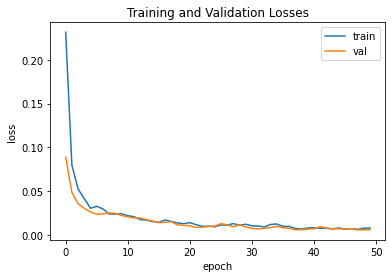

In [167]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 12)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [168]:
# model_json = model.to_json()
# with open("siamesemodel-triplet-loss.json", "w") as json_file:
#     json_file.write(model_json)
# #serialize weights to HDF5
# model.save_weights("siamesemodel-triplet-loss.h5")
# print("Saved model to disk")

In [169]:

X_train_eval = base_model.predict(train_q1_seq)
X_test_eval = base_model.predict(test_q1_seq)
# The above embedding outputs will be used to predict. 

# TSNE - dimensionality reduction for data visualization
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_eval)

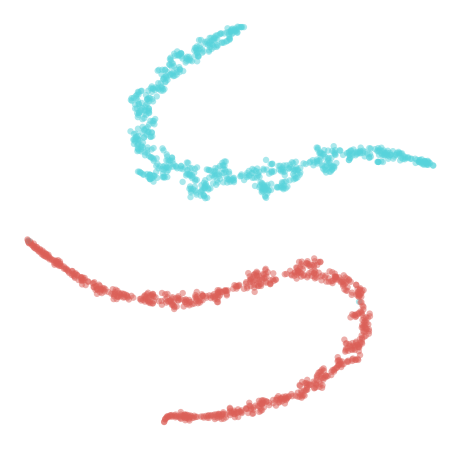

In [170]:
def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

scatter(train_tsne_embeds, y_train_class)

In [171]:
# classifier that computes the class of a specific embedding for prediction purposes
classifier_input = Input(shape=(2,))
classifier_output = Dense(2, activation='softmax')(classifier_input)
classifier_model = Model(classifier_input, classifier_output)

# onehot encoding vectors to 2 classes
Y_train_onehot = np_utils.to_categorical(y_train_class, 2)
Y_test_onehot = np_utils.to_categorical(y_test_class, 2)

classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
classifier_model.fit(X_train_eval,Y_train_onehot, validation_data=(X_test_eval, Y_test_onehot),epochs=100)

Epoch 1/100
49/49 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.9987 - val_loss: 0.6362 - val_accuracy: 0.9959
Epoch 2/100
49/49 [==============================] - 0s 2ms/step - loss: 0.6130 - accuracy: 0.9987 - val_loss: 0.5967 - val_accuracy: 0.9959
Epoch 3/100
49/49 [==============================] - 0s 2ms/step - loss: 0.5729 - accuracy: 0.9987 - val_loss: 0.5598 - val_accuracy: 0.9959
Epoch 4/100
49/49 [==============================] - 0s 2ms/step - loss: 0.5359 - accuracy: 0.9987 - val_loss: 0.5258 - val_accuracy: 0.9959
Epoch 5/100
49/49 [==============================] - 0s 2ms/step - loss: 0.5017 - accuracy: 0.9987 - val_loss: 0.4944 - val_accuracy: 0.9959
Epoch 6/100
49/49 [==============================] - 0s 2ms/step - loss: 0.4703 - accuracy: 0.9987 - val_loss: 0.4654 - val_accuracy: 0.9959
Epoch 7/100
49/49 [==============================] - 0s 2ms/step - loss: 0.4413 - accuracy: 0.9987 - val_loss: 0.4384 - val_accuracy: 0.9959
Epoch 8/100
4

In [172]:

input = X_test_eval
y_pred = classifier_model.predict(input)
y_pred=np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test_onehot,axis = 1)
print("Classification report on validation data \n",classification_report(y_test, y_pred, digits=4))



Classification report on validation data 
               precision    recall  f1-score   support

           0     0.9913    1.0000    0.9957       229
           1     1.0000    0.9922    0.9961       255

    accuracy                         0.9959       484
   macro avg     0.9957    0.9961    0.9959       484
weighted avg     0.9959    0.9959    0.9959       484



In [173]:
df_test = pd.DataFrame(columns=['text', 'label', 'stance'])

for target in ['Donald Trump','Hillary Clinton']:
    
    with open(test_data_file_m, 'r') as testfile:
        for line in testfile:
            line = line.replace('#SemST', '').strip()
            line = line.split('\t')
            if line[0].strip() != 'ID' and target in line[1].strip():
                tweet = line[2]
                df_test.loc[len(df_test)] = [str(tweet),0, line[3]]

In [174]:
df_test

,text,label,stance
0,@chriswallace There may be 2000 nutjobs of tha...,0,NONE
1,@realDonaldTrump u talk a big bigoted talk & y...,0,AGAINST
2,@ac360 @ananavarro @andersoncooper #AC360 HECK...,0,FAVOR
3,Watching what Donald Trump said about Mexicans...,0,AGAINST
4,"""Are people deaf to the word illegal? I'm all ...",0,NONE
...,...,...,...
467,.@HillaryClinton Looking 4ward 2 hearing your ...,0,FAVOR
468,@mataharikrishna I'm loving it too! Draw that ...,0,NONE
469,"@finneyk Can't stand @msnbc anymore, but hope ...",0,FAVOR
470,Hillary can't create jobs! Last time she had a...,0,AGAINST


In [175]:
df_test_2 = pd.DataFrame()
df_a = df_ent_train[df_ent_train['target'] == 'FOXA_DIS'][1200:1600]

df_test_new = pd.DataFrame(columns=['text', 'label', 'stance'])
df_test_new['text'] = df_a['tweet']
df_test_new['label'] = 1
df_test_new['stance'] = df_a['stance']

df_test = df_test.append(df_test_new)
df_test

,text,label,stance
0,@chriswallace There may be 2000 nutjobs of tha...,0,NONE
1,@realDonaldTrump u talk a big bigoted talk & y...,0,AGAINST
2,@ac360 @ananavarro @andersoncooper #AC360 HECK...,0,FAVOR
3,Watching what Donald Trump said about Mexicans...,0,AGAINST
4,"""Are people deaf to the word illegal? I'm all ...",0,NONE
...,...,...,...
1595,Disney CEO Bob Iger To Reportedly Stay On To H...,1,comment
1596,"If the Disney/Fox deal goes through, #Collider...",1,comment
1597,"Check out CHILDRENS , VHS TAPES LOT OF 26, In...",1,unrelated
1598,@SpencerMemes If Disney buys some of Fox that...,1,comment


In [122]:
# np.unique(df_hlt_train['target'])

array(['AET_HUM', 'ANTM_CI', 'CI_ESRX', 'CVS_AET'], dtype=object)

In [176]:
# df_test_2 = pd.DataFrame()
# df_a = df_hlt_train[df_hlt_train['target'] == 'AET_HUM'][300:400]
# df_b = df_hlt_train[df_hlt_train['target'] == 'ANTM_CI'][300:400]
# df_c = df_hlt_train[df_hlt_train['target'] == 'CI_ESRX'][300:400]
# df_d = df_hlt_train[df_hlt_train['target'] == 'CVS_AET'][300:400]

# df_test_2 = df_test_2.append(df_a, ignore_index=True)
# df_test_2 = df_test_2.append(df_b, ignore_index=True)
# df_test_2 = df_test_2.append(df_c, ignore_index=True)
# df_test_2 = df_test_2.append(df_d, ignore_index=True)
# df_test_new = pd.DataFrame(columns=['text', 'label', 'stance'])
# df_test_new['text'] = df_test_2['tweet']
# df_test_new['label'] = 1
# df_test_new['stance'] = df_test_2['stance']

# df_test = df_test.append(df_test_new)
# df_test

In [177]:
here---

SyntaxError: invalid syntax (3375635915.py, line 1)

In [178]:


    
df_test['clean_text'] = df_test['text'].apply(lambda x: remove_url(str(x)))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: remove_emoji(str(x)))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: remove_html(str(x)))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: remove_punct(str(x)))
df_test['clean_text'] = df_test['clean_text'].apply(word_tokenize)
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: [word.lower() for word in x])
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: [word for word in x if word not in stop])
df_test['clean_text'] = df_test['clean_text'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df_test['clean_text'] = df_test['clean_text'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
df_test['clean_text'] = df_test['clean_text'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df_test['clean_text'] = df_test['clean_text'].apply(
    lambda x: [word for word in x if word not in stop])
df_test['clean_text'] = [' '.join(map(str, l)) for l in df_test['clean_text']]

In [179]:
df_test['clean_text'] = df_test['clean_text'].astype(str)
y_q1_seq = t.texts_to_sequences(df_test['clean_text'].values)


y_q1_seq = pad_sequences(y_q1_seq, maxlen=max_len, padding='post')
y_test_eval = base_model.predict(y_q1_seq)

input_2 = y_test_eval
y_pred_2 = classifier_model.predict(input_2)

y2_test_class = np.asarray(df_test['label']).astype('float32')
y2_test_onehot = np_utils.to_categorical(y2_test_class, 2)

y_pred_2=np.argmax(y_pred_2, axis=1)
y_test_2 = np.argmax(y2_test_onehot,axis = 1)
print("")
print("Classification report on Test data \n",classification_report(y_test_2, y_pred_2, digits=4))


Classification report on Test data 
               precision    recall  f1-score   support

           0     0.9812    0.9958    0.9884       472
           1     0.9949    0.9775    0.9861       400

    accuracy                         0.9874       872
   macro avg     0.9881    0.9866    0.9873       872
weighted avg     0.9875    0.9874    0.9874       872



# predicting above model on other target and getting that data

In [180]:
print(len(df_hlt_train))

22101


In [181]:
# df_oth = pd.DataFrame(columns=['text', 'label', 'stance'])

df_oth = pd.DataFrame()
#df_oth['text'] = df_ent_train['tweet']
df_oth['text'] = df_hlt_train['tweet']
df_oth['label'] = "NA"
#df_oth['stance'] = df_ent_train['stance']
df_oth['stance'] = df_hlt_train['stance']


In [182]:
df_oth

,text,label,stance
0,"Deals , deals and more ...CVS buying Aetna for...",NA,support
1,Do investigating all the Chinese hacks: OPM wh...,NA,unrelated
2,INVESTMENT NEWS Zacks Industry Outlook Highlig...,NA,unrelated
3,#TSXVenture #stocks: #Merger #Acquisition: Ant...,NA,unrelated
4,#NTT #NipponTelegraph &amp; #Telephone Corpora...,NA,unrelated
...,...,...,...
22096,"Recent industry milestones like #Amazon, #Berk...",NA,comment
22097,"How the CVS, Aetna Deal Will Overhaul Healthca...",NA,comment
22098,@berthacoombs Obama and DOJ must decide if the...,NA,comment
22099,Part ANIMA HUMANA: What is A listing Contract?...,NA,unrelated


In [183]:
#  with open(train_data_file_m, 'r') as testfile:
#         for line in testfile:
            
#             line = line.replace('#SemST', '').strip()
#             line = line.split('\t')
            
#             if line[0].strip() != 'ID' and test_on in line[1].strip():
#                 tweet = line[2]
#                 #print(tweet)
#                 df_oth.loc[len(df_oth)] = [str(tweet),'NA',line[3]]
                

In [184]:
df_oth['clean_text'] = df_oth['text'].apply(lambda x: remove_url(str(x)))
df_oth['clean_text'] = df_oth['clean_text'].apply(lambda x: remove_emoji(str(x)))
df_oth['clean_text'] = df_oth['clean_text'].apply(lambda x: remove_html(str(x)))
df_oth['clean_text'] = df_oth['clean_text'].apply(lambda x: remove_punct(str(x)))
df_oth['clean_text'] = df_oth['clean_text'].apply(word_tokenize)
df_oth['clean_text'] = df_oth['clean_text'].apply(lambda x: [word.lower() for word in x])
df_oth['clean_text'] = df_oth['clean_text'].apply(lambda x: [word for word in x if word not in stop])
df_oth['clean_text'] = df_oth['clean_text'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df_oth['clean_text'] = df_oth['clean_text'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
df_oth['clean_text'] = df_oth['clean_text'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df_oth['clean_text'] = df_oth['clean_text'].apply(
    lambda x: [word for word in x if word not in stop])
df_oth['clean_text'] = [' '.join(map(str, l)) for l in df_oth['clean_text']]

In [185]:
df_oth['stance'][5]

'comment'

In [186]:
df_oth['clean_text'] = df_oth['clean_text'].astype(str)
oth_q1_seq = t.texts_to_sequences(df_oth['clean_text'].values)

In [187]:
oth_q1_seq = pad_sequences(oth_q1_seq, maxlen=max_len, padding='post')
oth_test_eval = base_model.predict(oth_q1_seq)

In [188]:
input_3 = oth_test_eval
oth_pred_3 = classifier_model.predict(input_3)


In [189]:
oth_pred_3

array([[0.01769373, 0.9823063 ],
       [0.97473735, 0.02526271],
       [0.9808865 , 0.01911353],
       ...,
       [0.12097012, 0.8790299 ],
       [0.01264185, 0.9873582 ],
       [0.9434776 , 0.05652239]], dtype=float32)

In [190]:
oth_pred_4=np.argmax(oth_pred_3, axis=1)
oth_pred_4

array([1, 0, 0, ..., 1, 1, 0])

In [191]:
oth_pred_3[0]

array([0.01769373, 0.9823063 ], dtype=float32)

In [192]:
unique,count = np.unique(oth_pred_4,return_counts=True)
dict(zip(unique, count))

{0: 5645, 1: 16456}

# Change the file name 

In [140]:
oth_pred_3

array([[0.9939083 , 0.00609171],
       [0.02480351, 0.9751965 ],
       [0.06026034, 0.9397397 ],
       ...,
       [0.99692506, 0.0030749 ],
       [0.06324334, 0.9367567 ],
       [0.02469326, 0.9753067 ]], dtype=float32)

In [193]:
import json
threshold = [0.50, 0.60, 0.70, 0.80, 0.90]
for th in threshold:
    data = []
    
    for i in range(len(oth_pred_3)):
        if oth_pred_3[i][1] >= th:
            values = {}
            values['tweet'] = df_oth['text'][i]
            values["stance"] = df_oth['stance'][i]
            data.append(values)
    jsonString = json.dumps(data)
    with open("rich_data/ent_pol_hlt/ent_pol_hlt" + str(th) + ".json", "w") as jsonFile:
        jsonFile.write(jsonString)
        jsonFile.close()
    
# file_name = 'rich_data/hlt_pol_ent/hlt_pol_ent' + str(th) +'.txt'
# with open(file_name,'w') as f:
#     for i in range(len(oth_pred_3)):
#         if oth_pred_4[i] == 1:
#             if oth_pred_3[i][1] >= th:
#                 c+= 1
#                 f.write(str(df_oth['text'][i]).strip() + "\t" + str(df_oth['stance'][i]).strip())
#                 f.write('\n')

In [71]:
c

3458

In [83]:
c = 0
with open(file_name,'r') as f:
    for i in f:
        c += 1
c

7022

In [78]:
print(file_name)

rich_data/hlt_pol_ent/hlt_pol_ent0.5.txt


In [71]:
# with open('rich_data.txt','w') as f:
#     for tweet in rich_data:
#         f.write(tweet)
#         f.write('\n')

In [94]:
df_rich_data.to_csv('rich_data.csv',sep='\t')
